# <div style = 'background-color:#50474E'> <center><font color='#F2DD6C'>Construcción de un Modelo de Detección de Fraude</div><div style = 'background-color:#50474E'> <center>.<font color='#50474E'></div>

Este notebook documenta la construcción de un modelo predictivo para la detección de fraude a partir de un conjunto de datos de aproximadamente 250.000 registros. Se desarrollan etapas de ingeniería de características, reducción de dimensionalidad y entrenamiento de un modelo Random Forest, priorizando un balance entre desempeño y simplicidad. Finalmente, se analizan las variables más relevantes mediante técnicas de interpretación global para comprender su impacto en las decisiones del modelo.
Precaución, la ejecución completa del notebook presenta una complejidad elevada, pudiendo demandar más de 35 minutos de procesamiento debido al tamaño del conjunto de datos.

#### Indice

<div class="alert alert-block alert-info" style="margin-top: 20px">

1.  [Analisis exploratorio de los datos](#0)<br>
2.  [Preparación y limpieza de los datos](#1)<br>
3.  [Modelado y evaluación](#2) <br>
4.  [Concluciones](#3) <br>

</div>

In [1]:
import warnings
warnings.filterwarnings("ignore") # Filtrar avisos

import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('Fraude-Dataset.csv')

In [3]:
df.sample(3)

,transaction id,timestamp,transaction type,merchant_category,amount (INR),transaction_status,sender_age_group,receiver_age_group,sender_state,sender_bank,receiver_bank,device_type,network_type,hour_of_day,day_of_week,is_weekend,sender_upi_id,receiver_upi_id,risk_score,is_fraud
99486,TXN0000099487,2024-03-17 17:27:06,Recharge,Food,215,SUCCESS,26-35,26-35,Rajasthan,HDFC,SBI,Android,WiFi,17,Sunday,1,8455324074@okidfc,8536381739@oksbi,192.5,0
138301,TXN0000138302,2024-10-31 09:15:21,P2M,Food,443,SUCCESS,36-45,36-45,Telangana,PNB,HDFC,iOS,5G,9,Thursday,0,6417825271@oksbi,9594106879@okhdfcbank,266.5,0
43946,TXN0000043947,2024-07-18 18:30:04,P2M,Entertainment,158,SUCCESS,26-35,26-35,Maharashtra,PNB,Axis,Android,WiFi,18,Thursday,0,8127985075@oksbi,6129760345@okkotak,169.0,0


In [4]:
df.columns = ['ID', 'Fecha', 'Tipo_Trans', 'Rubro', 'Monto', 'Status', 'Edad_Envio', 'Edad_Recep', 'Ubic_Envio', 'Banco_Envio', 'Banco_Recep', 'Dispositivo', 'Red', 'Hora', 'Dia', 'Fin_de_Semana', 'Envio_ID', 'Recep_ID', 'Score_Riesgo', 'Fraude']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             250000 non-null  object 
 1   Fecha          250000 non-null  object 
 2   Tipo_Trans     250000 non-null  object 
 3   Rubro          250000 non-null  object 
 4   Monto          250000 non-null  int64  
 5   Status         250000 non-null  object 
 6   Edad_Envio     250000 non-null  object 
 7   Edad_Recep     250000 non-null  object 
 8   Ubic_Envio     250000 non-null  object 
 9   Banco_Envio    250000 non-null  object 
 10  Banco_Recep    250000 non-null  object 
 11  Dispositivo    250000 non-null  object 
 12  Red            250000 non-null  object 
 13  Hora           250000 non-null  int64  
 14  Dia            250000 non-null  object 
 15  Fin_de_Semana  250000 non-null  int64  
 16  Envio_ID       250000 non-null  object 
 17  Recep_ID       250000 non-nul

In [6]:
df.isnull().sum() # Mostrar cuantos nulos hay por campo.

ID               0
Fecha            0
Tipo_Trans       0
Rubro            0
Monto            0
Status           0
Edad_Envio       0
Edad_Recep       0
Ubic_Envio       0
Banco_Envio      0
Banco_Recep      0
Dispositivo      0
Red              0
Hora             0
Dia              0
Fin_de_Semana    0
Envio_ID         0
Recep_ID         0
Score_Riesgo     0
Fraude           0
dtype: int64

## <div style = 'background-color:black'> <center><font color='white'>① Analisis exploratorio de los datos (EDA) </font></div><a id="0"></a>

<AxesSubplot:xlabel='Fraude', ylabel='Monto'>

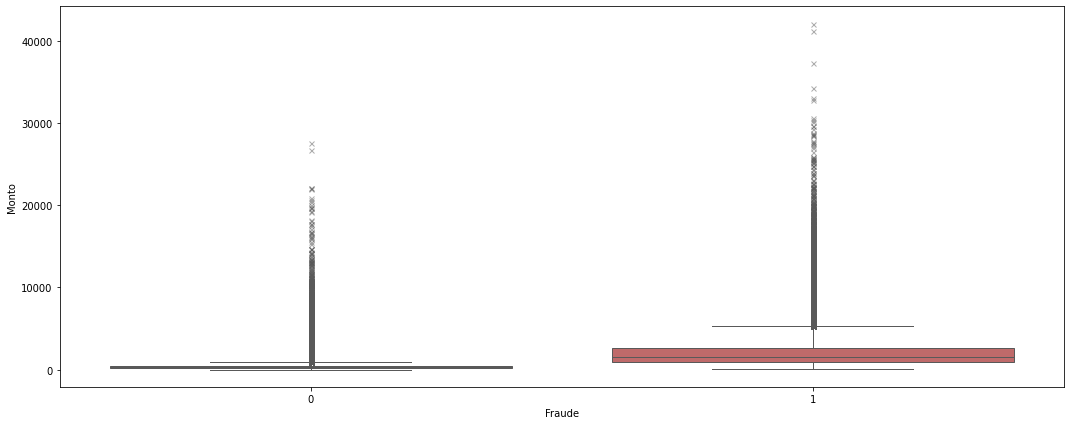

In [7]:
plt.figure(figsize=(18, 7))
sns.boxplot(x='Fraude', y='Monto', data=df, color='indianred', fliersize=5,           # tamaño de los outliers
    flierprops={'marker':'x', 'color':'orange', 'alpha':0.5})

Gran concentración de operaciones de bajo importe y un número reducido de transacciones con montos significativamente elevados. Estos valores extremos generan una cola larga que domina la escala y provoca que en representaciones gráficas estas cajas y sus respectivos bigotes queden visualmente comprimidos. 
Tambien se puede observar en la caja de fraudes que tienen una variabilidad superior y se presentan tambien en montos superiores.

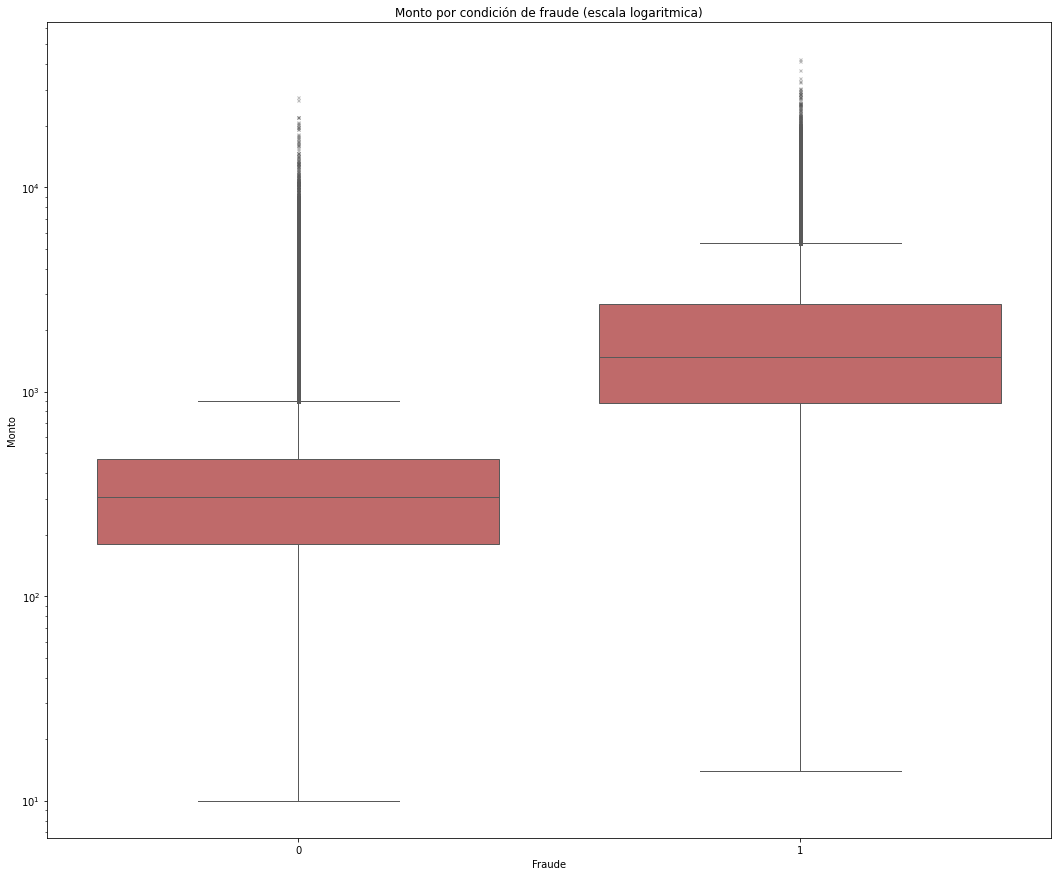

In [8]:
plt.figure(figsize=(18, 15))
sns.boxplot(
    x='Fraude', y='Monto', data=df,
    color='indianred',
    fliersize=3,
    flierprops={'marker':'x', 'color':'orange', 'alpha':0.4}
)

plt.yscale('log')
plt.title('Monto por condición de fraude (escala logaritmica)')
plt.show()

Esta asimetría justifica la aplicación de transformaciones (por ejemplo, escala logarítmica como se ve en este grafico de arriba). Donde se ve el mismo grafico pero expresado de otra forma para visualizar mejor las cajas. 

Lo que se puede observar en general:

En los casos detectados como normales [0]: Se muestra un comportamiento típico de transacciones legítimas donde la gran mayoría corresponden a bajos montos, pero tambien existen excepciones frecuentes que alcanzan alturas considerables o compras validas de alto valor.

En los casos clasificados como fraude [1]: Hay montos significativamente mayores, el bigote inferior de este gráfico ya es más grande que todo el gráfico de las operaciones legitimas, significa que el fraude casi nunca ocurre con montos pequeños. El piso desde donde se genera el fraude es mucho más alto que el promedio de una transacción normal. Entonces existen fraudes de montos muy elevados que rompen incluso con el promedio de los montos fraudulentos que ya de por sí eran elevados.

En resumen, los usuarios en promedio que realizan fraudes en este conjunto de datos no están interesados en pasar desapercibidos realizando operaciones con montos pequeños si no que van directamente por realizar transacciones de alto valor que superan con creces el gasto cotidiano de un usuario normal.
    

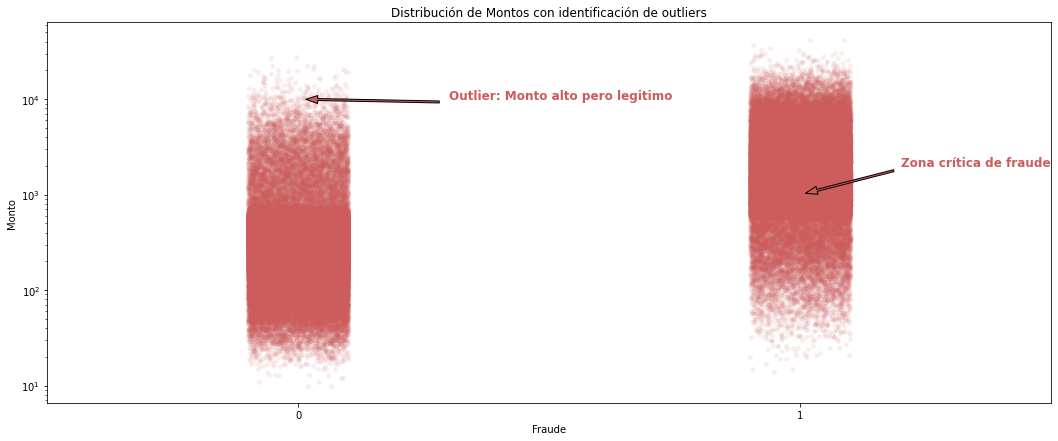

In [9]:
plt.figure(figsize=(18, 7))
sns.stripplot(
    x='Fraude', y='Monto', data=df,
    color='indianred', alpha=0.1, jitter=True
)

plt.annotate(
    'Outlier: Monto alto pero legitimo', 
    xy=(0, 10000),          # Dónde termina la flecha (X=0 es la columna 'Normal', Y es el outlier)
    xytext=(0.3, 10000),    # Dónde empieza el texto
    arrowprops=dict(facecolor='indianred', shrink=0.05, width=2, headwidth=8),
    fontsize=12, color='indianred', fontweight='bold'
)

plt.annotate(
    'Zona crítica de fraude', 
    xy=(1, 1000),          # Punto en la columna de Fraude
    xytext=(1.2, 2000),    
    arrowprops=dict(facecolor='indianred', shrink=0.05, width=2, headwidth=8),
    fontsize=12, color='indianred', fontweight='bold'
)

plt.yscale('log')
plt.title('Distribución de Montos con identificación de outliers')
plt.show()

Otra forma de ver la distribución de datos, en la columna de operaciones normales, se ve una concentración de puntos (mancha negra muy densa en la parte baja), eso indica que el grueso de transacciones legítimas son de montos pequeños o medianos, arriba marco que existen outliers de estas operaciones pero son totalmente autenticas.

En el eje 1 (operaciones fraudulentas) la mancha oscura está más arriba que en el grupo 0, Se confirma que el núcleo del fraude se produce con montos superiores a la transacción promedio normal.

<AxesSubplot:ylabel='Tipo_Trans'>

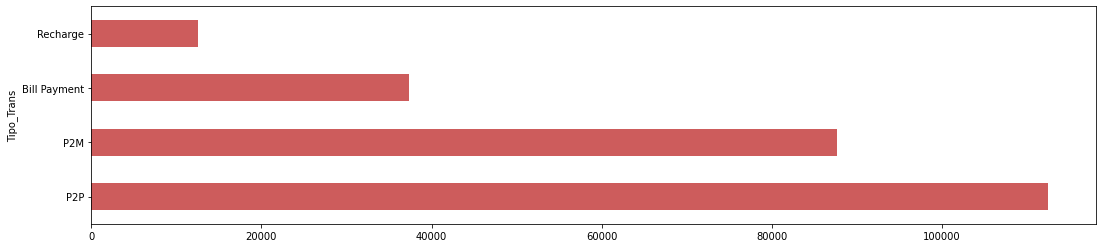

In [10]:
df['Tipo_Trans'].value_counts().plot(kind='barh', color='indianred', figsize=(18, 4))

Se puede observar que las operaciones con mas frecuencias son las realizadas como P2M y P2P.

**P2M = Person to Merchant** (pagos de una persona a un comercio, ejemplo pagos con QR). Donde los ilicitos mas usados en este tipo de transaccion es el abuso operativo y contracargos en pagos.

**P2P = Person to Person** (transferencias entre personas, ejemplo transferencias entre familiares). El delito que se suele cometer en estos casos es el fraude de ingenieria social, uso de cuentas intermediarias, cuentas de terceros que prestan CBU/Alias, etc.

<AxesSubplot:ylabel='Rubro'>

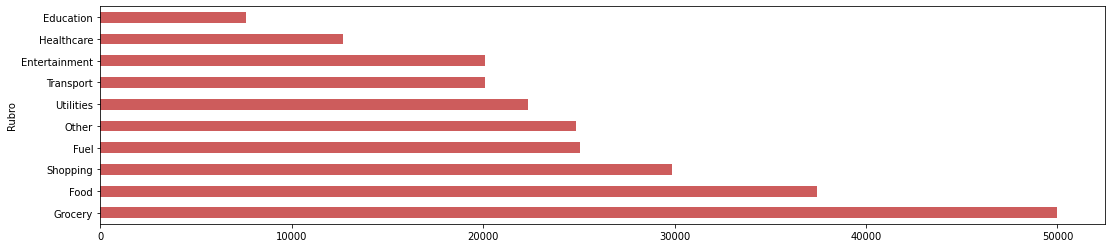

In [11]:
df['Rubro'].value_counts().plot(kind='barh', color='indianred', figsize=(18, 4))

Los rubros más utilizados corresponden, en primer lugar, a Grocery, asociado a la compra de alimentos y productos de consumo diario (almacenes y supermercados). Le sigue el rubro Food, también vinculado a la adquisición de alimentos. En tercer lugar se ubica Shopping que agrupa compras en comercios minoristas no esenciales, tales como indumentaria, calzado, electrónica, artículos para el hogar.

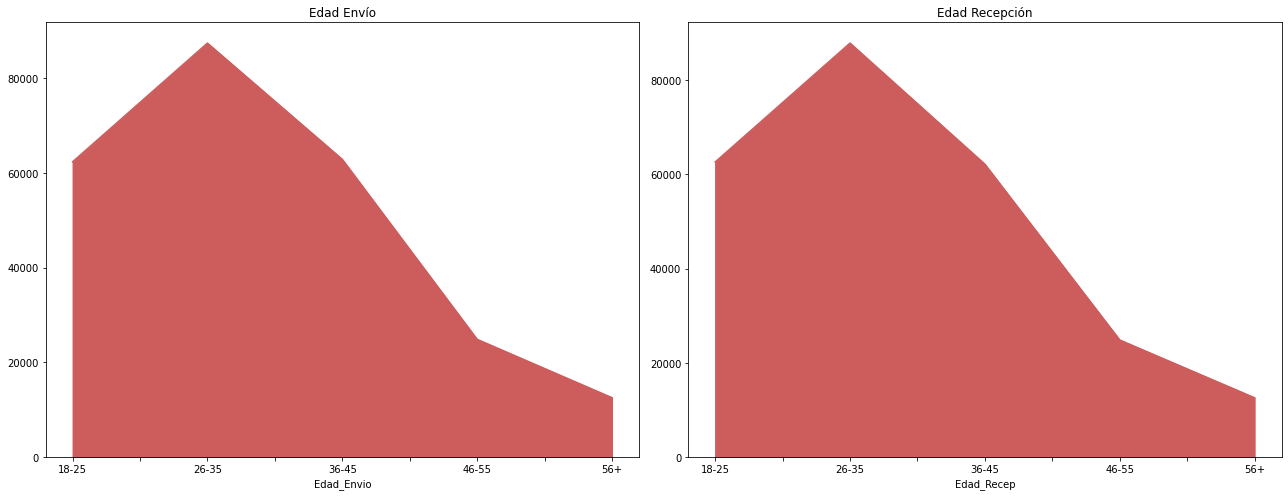

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

df['Edad_Envio'].value_counts().sort_index().plot(
    kind='area', ax=axes[0], title='Edad Envío', color='indianred'
)

df['Edad_Recep'].value_counts().sort_index().plot(
    kind='area', ax=axes[1], title='Edad Recepción', color='indianred'
)

plt.tight_layout()
plt.show()

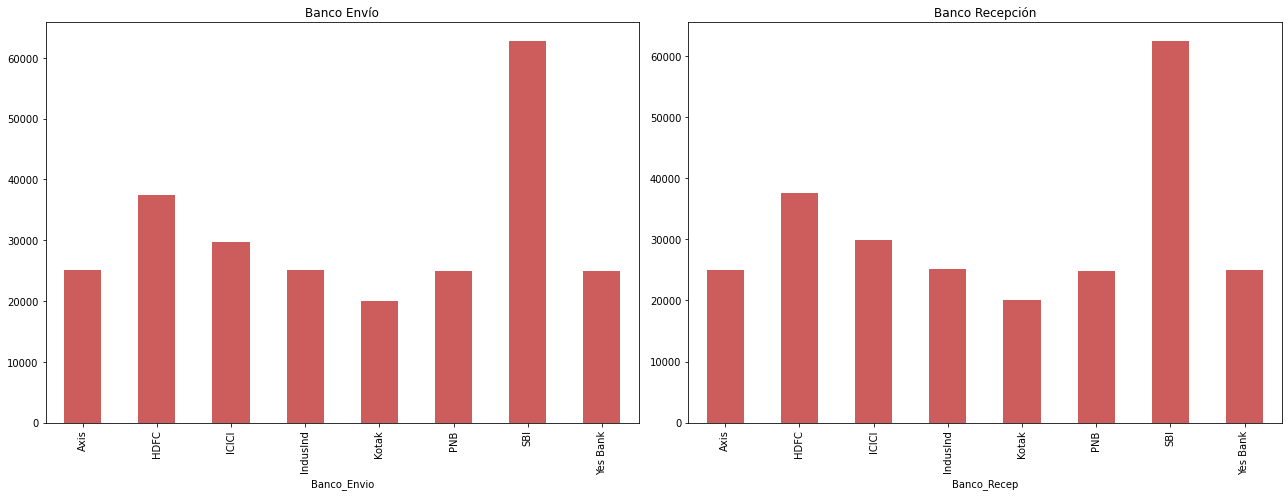

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

df['Banco_Envio'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0], title='Banco Envío', color='indianred'
)

df['Banco_Recep'].value_counts().sort_index().plot(
    kind='bar', ax=axes[1], title='Banco Recepción', color='indianred'
)

plt.tight_layout()
plt.show()

Ambos gráficos presentan un comportamiento prácticamente idéntico a nivel visual: la forma general de la distribución, las concentraciones de valores y las tendencias principales coinciden casi por completo (Sucede lo mismo con el grafico anterior de Edad Envio vs Edad Recepción).
Sin embargo al analizar el código de abajo, donde se hace el conteo de valores, se observa que existen pequeñas diferencias entre ambos campos. Estas discrepancias evidencian que a nivel de datos los conjuntos no son exactamente iguales.

In [14]:
df['Banco_Envio'].value_counts().sort_index()

Banco_Envio
Axis        25042
HDFC        37485
ICICI       29769
IndusInd    25173
Kotak       20032
PNB         24946
SBI         62693
Yes Bank    24860
Name: count, dtype: int64

In [15]:

df['Banco_Recep'].value_counts().sort_index()


Banco_Recep
Axis        24992
HDFC        37651
ICICI       29944
IndusInd    25086
Kotak       20138
PNB         24802
SBI         62378
Yes Bank    25009
Name: count, dtype: int64

In [16]:
# Resta de los dos conteos para ver las diferencias que hay que son minimas para la cantidad de valores de los datos.
vc_envio = df['Banco_Envio'].value_counts().sort_index()
vc_recep = df['Banco_Recep'].value_counts().sort_index()

vc_envio - vc_recep

Banco_Envio
Axis         50
HDFC       -166
ICICI      -175
IndusInd     87
Kotak      -106
PNB         144
SBI         315
Yes Bank   -149
Name: count, dtype: int64

Aqui se puede observar que la diferencia es muy poca, que en gran cantidad de datos hace que sea casi imperceptible en un grafico.

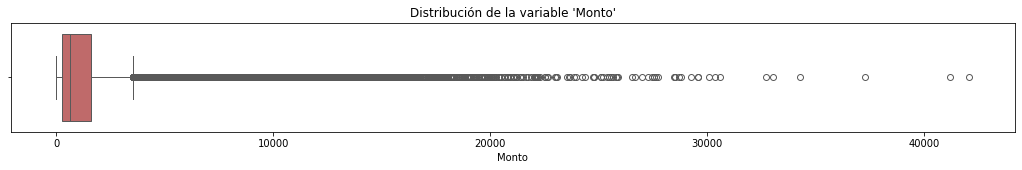

In [17]:
plt.figure(figsize=(18, 2))  
sns.boxplot(x=df['Monto'], color="indianred")
plt.title("Distribución de la variable 'Monto'")
plt.show()

El campo "Monto" como se puede ver en este diagrama de caja, muestra un sesgo hacia la derecha (positivo) del gráfico. Por su mediana tan cerca del 0, puedo inferir que el 50% de los datos están concentrados en un rango muy bajo pero tambien afectados por valores extremos que estiran los promedios hacia la derecha.

<AxesSubplot:ylabel='Dispositivo'>

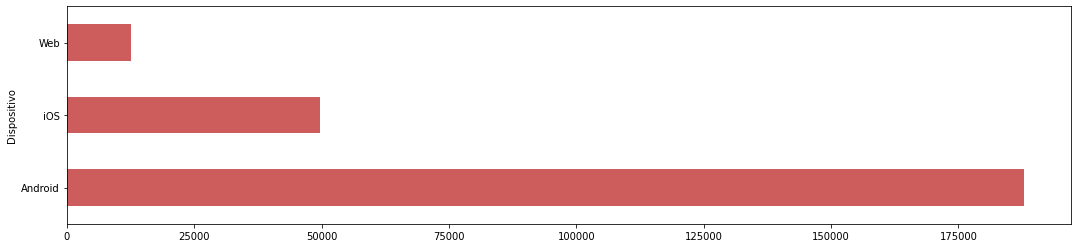

In [18]:
df['Dispositivo'].value_counts().plot(kind='barh', color="indianred", figsize=(18, 4))

Se puede observar que el dispositivo mas utilizado es con sistema operativo Android por mucha diferencia. Los que usan iOS llegan a ser un 25% de los que usan Android.

<AxesSubplot:ylabel='Red'>

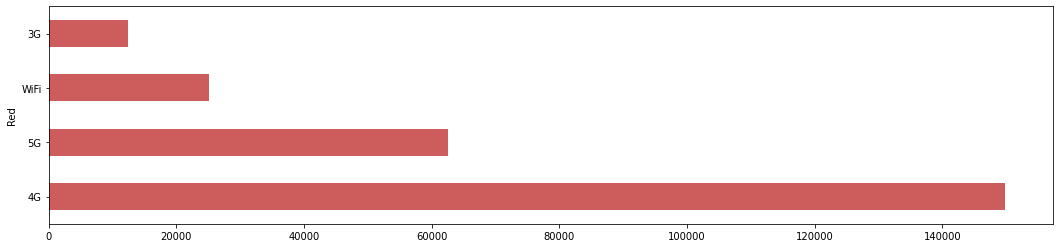

In [19]:
df['Red'].value_counts().plot(kind='barh', color="indianred", figsize=(18, 4))

(124800.0, 125100.0)

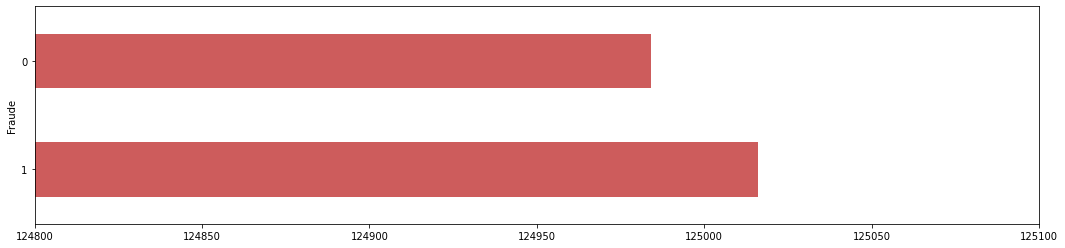

In [20]:
vc = df['Fraude'].value_counts(normalize=False)
ax = vc.plot(kind='barh', color="indianred", figsize=(18, 4))
ax.set_xlim(124800, 125100) # Hago zoom en el grafico para poder ver la pequeña diferencia que hay entre 0 y 1.

In [21]:
df['Fraude'].value_counts().sort_index() # Para ver los numeros que tiene cada valor.

Fraude
0    124984
1    125016
Name: count, dtype: int64

In [22]:
df.sample()


,ID,Fecha,Tipo_Trans,Rubro,Monto,Status,Edad_Envio,Edad_Recep,Ubic_Envio,Banco_Envio,Banco_Recep,Dispositivo,Red,Hora,Dia,Fin_de_Semana,Envio_ID,Recep_ID,Score_Riesgo,Fraude
41587,TXN0000041588,2024-11-06 21:29:57,P2M,Food,48,SUCCESS,26-35,18-25,Uttar Pradesh,ICICI,Axis,Android,WiFi,21,Wednesday,0,9551847026@oksbi,7714546147@okhdfcbank,129.0,0


## <div style = 'background-color:#50474E'> <center><font color='white'>② Preparación y limpieza de los datos </font></div> <a id="1"></a>

La primera columna a transformar es “Fecha”, ya que se encuentra almacenada como texto. Se convierte a tipo int64, quedando expresada como la cantidad de nanosegundos transcurridos desde el origen temporal (epoch).

In [23]:
df['Fecha'] = pd.to_datetime(df['Fecha']) # Convierte el campo desde un string a datetime de pandas.
df['Fecha'] = df['Fecha'].astype('int64') // 1e9 # Convierte a int64 dando la cantidad de nanosegundos desde 01/01/1970 luego divide por 1e9 para dejarlo en segundos.

Ahora convierto el campo "Tipo de Transaccion" asignando valores desde el 0 al 3 de forma arbitraria. Luego mas abajo en el codigo, el campo "Rubro" lo codificaré segun frecuencia de aparición en el set de datos.

In [24]:
df['Tipo_Trans'].value_counts()

Tipo_Trans
P2P             112445
P2M              87660
Bill Payment     37368
Recharge         12527
Name: count, dtype: int64

In [25]:
df['Tipo_Trans'] = df['Tipo_Trans'].replace({
    'P2P': 0,
    'P2M': 1,
    'Bill Payment': 2,
    'Recharge': 3})

In [26]:
df['Rubro'].value_counts() # Conteo de repeticiones.

Rubro
Grocery          49966
Food             37464
Shopping         29872
Fuel             25063
Other            24828
Utilities        22338
Transport        20105
Entertainment    20103
Healthcare       12663
Education         7598
Name: count, dtype: int64

In [27]:
freq = df['Rubro'].value_counts()
df['Rubro'] = df['Rubro'].map(freq)

El campo "Status" lo codifico asignando 0 y 1 a los dos tipos de variables disponibles, "Success" y "Failed".

In [28]:
df['Status'].value_counts()

Status
SUCCESS    237624
FAILED      12376
Name: count, dtype: int64

In [29]:
df['Status'] = df['Status'].replace({
    'SUCCESS': 0,
    'FAILED': 1})    

En los siguientes 5 campos "Edad_Envio", "Edad_Recep", "Ubic_Envio", "Banco_Envio" y "Banco_Recep" aplico codificación por frecuencia para no generar muchas columnas adicionales, asignandole un valor de acuerdo a la frecuencia de ocurrencia de cada variable.

In [30]:
df['Edad_Envio'].value_counts()

Edad_Envio
26-35    87432
36-45    62873
18-25    62345
46-55    24841
56+      12509
Name: count, dtype: int64

In [31]:
freq = df['Edad_Envio'].value_counts()
df['Edad_Envio'] = df['Edad_Envio'].map(freq)

In [32]:
df['Edad_Recep'].value_counts()

Edad_Recep
26-35    87864
18-25    62611
36-45    62151
46-55    24823
56+      12551
Name: count, dtype: int64

In [33]:
freq = df['Edad_Recep'].value_counts()
df['Edad_Recep'] = df['Edad_Recep'].map(freq)

In [34]:
df['Ubic_Envio'].value_counts()

Ubic_Envio
Maharashtra       37427
Uttar Pradesh     30125
Karnataka         29756
Tamil Nadu        25367
Delhi             24870
Telangana         22435
Gujarat           20061
Andhra Pradesh    20006
Rajasthan         19981
West Bengal       19972
Name: count, dtype: int64

In [35]:
freq = df['Ubic_Envio'].value_counts()
df['Ubic_Envio'] = df['Ubic_Envio'].map(freq)

In [36]:
df['Banco_Envio'].value_counts()

Banco_Envio
SBI         62693
HDFC        37485
ICICI       29769
IndusInd    25173
Axis        25042
PNB         24946
Yes Bank    24860
Kotak       20032
Name: count, dtype: int64

In [37]:
freq = df['Banco_Envio'].value_counts()
df['Banco_Envio'] = df['Banco_Envio'].map(freq)

In [38]:
df['Banco_Recep'].value_counts()

Banco_Recep
SBI         62378
HDFC        37651
ICICI       29944
IndusInd    25086
Yes Bank    25009
Axis        24992
PNB         24802
Kotak       20138
Name: count, dtype: int64

In [39]:
freq = df['Banco_Recep'].value_counts()
df['Banco_Recep'] = df['Banco_Recep'].map(freq)

Los campos "Dispositivos" y "Red" se reexpresaran asignando numeros a cada tipo de resultado.

In [40]:
df['Dispositivo'].value_counts()

Dispositivo
Android    187777
iOS         49613
Web         12610
Name: count, dtype: int64

In [41]:
df['Dispositivo'] = df['Dispositivo'].replace({
    'Android': 0,
    'iOS': 1,
    'Web': 2
    })

In [42]:
df['Red'].value_counts()

Red
4G      149813
5G       62582
WiFi     25134
3G       12471
Name: count, dtype: int64

In [43]:
df['Red'] = df['Red'].replace({
    '4G': 0,
    '5G': 1,
    'WiFi': 2,
    '3G': 3
    })

In [44]:
df['Dia'].value_counts()

Dia
Monday       36495
Sunday       36003
Wednesday    35700
Tuesday      35540
Friday       35496
Thursday     35432
Saturday     35334
Name: count, dtype: int64

In [45]:
freq = df['Dia'].value_counts()
df['Dia'] = df['Dia'].map(freq)

Los siguientes campos "Envio_ID" y "Recep_ID" contienen muchos valores o codigos con frecuencia unica por lo que codificarlos generaria una gran dimensionalidad. Procedo a extraer el nombre del proveedor (que viene luego del @), crear una nueva columna con este valor extraido y luego codificarlo numericamente.

In [46]:
df['Envio_ID'].value_counts()

Envio_ID
7608637542@okidfc     1
8846486512@okicici    1
9792220633@okidfc     1
9361465415@okuco      1
7934066452@okaxis     1
                     ..
8720624408@okaxis     1
7050087870@okuco      1
7932230725@okkotak    1
6476652844@okicici    1
9691624913@okuco      1
Name: count, Length: 250000, dtype: int64

In [47]:
df.sample(3)

,ID,Fecha,Tipo_Trans,Rubro,Monto,Status,Edad_Envio,Edad_Recep,Ubic_Envio,Banco_Envio,Banco_Recep,Dispositivo,Red,Hora,Dia,Fin_de_Semana,Envio_ID,Recep_ID,Score_Riesgo,Fraude
204211,TXN0000204212,1.727041e+09,1,20105,188,0,87432,24823,19972,62693,25009,0,1,21,36003,1,9560748861@okicici,8516854587@okidfc,199.0,0
26612,TXN0000026613,1.725569e+09,3,24828,195,0,87432,24823,22435,37485,62378,0,3,20,35432,0,8733937778@okaxis,7375145567@okicici,197.5,0
62194,TXN0000062195,1.716546e+09,0,49966,2883,0,62345,87864,37427,24860,62378,1,2,10,35496,0,9555139354@okaxis,8625291563@okuco,1491.5,1


In [48]:
df['Envio_ID'] = df['Envio_ID'].str.split('@').str[1] # Tomo cada valor de la columna que es texto y lo divido usando @ como separador.
# [1] es para seleccionar el segundo resultado de esa division, luego se graba en la misma columna "Envio_ID".

In [49]:
df['Recep_ID'].value_counts()

Recep_ID
8844927238@okkotak       2
8649164205@okidfc        1
9398748803@okkotak       1
8150399338@okicici       1
9513237680@okaxis        1
                        ..
8234331060@okhdfcbank    1
7854237575@okaxis        1
6998040614@okuco         1
6999352582@okaxis        1
7700778680@oksbi         1
Name: count, Length: 249999, dtype: int64

In [50]:
df['Recep_ID'] = df['Recep_ID'].str.split('@').str[1] # Mismo proceso en este campo.

In [51]:
df.sample(3) # Para ver como van quedando las columnas convertidas.

,ID,Fecha,Tipo_Trans,Rubro,Monto,Status,Edad_Envio,Edad_Recep,Ubic_Envio,Banco_Envio,Banco_Recep,Dispositivo,Red,Hora,Dia,Fin_de_Semana,Envio_ID,Recep_ID,Score_Riesgo,Fraude
179052,TXN0000179053,1.709588e+09,0,22338,146,0,62345,62611,22435,25042,24802,0,2,21,36495,0,okhdfcbank,oksbi,178.0,0
105682,TXN0000105683,1.723064e+09,1,29872,439,0,87432,62611,24870,24946,20138,0,1,21,35700,0,oksbi,okicici,324.5,0
114076,TXN0000114077,1.705680e+09,2,49966,365,0,24841,62611,25367,37485,62378,0,2,16,35496,0,oksbi,okidfc,262.5,0


Ahora procedo a codificar estas columnas recien extraido el nombre del proveedor, seran codificados por frecuencia.

In [52]:
freq = df['Envio_ID'].value_counts()
df['Envio_ID'] = df['Envio_ID'].map(freq)

freq = df['Recep_ID'].value_counts()
df['Recep_ID'] = df['Recep_ID'].map(freq)

#### Escalado de Datos

En este caso se utiliza un modelo Random Forest. Dado que este algoritmo está basado en árboles de decisión, los cuales realizan particiones del espacio de variables a partir de reglas de corte, el escalado de las variables no resulta necesario.

#### Ingenieria de caracteristicas

#### 1°
En algunos casos, dos señales consideradas de forma individual pueden no resultar especialmente críticas. Sin embargo, cuando ambas ocurren de manera simultánea, el nivel de riesgo aumenta de forma desproporcionada.

Por ejemplo, circular a alta velocidad o conducir bajo la lluvia, analizadas por separado, pueden no representar un peligro extremo. No obstante, la combinación de alta velocidad en condiciones de lluvia incrementa sustancialmente la probabilidad de un evento adverso.

De manera análoga, esta nueva característica busca capturar ese efecto de interacción, proporcionando al modelo una señal explícita que indica cuándo ambas condiciones se presentan en conjunto, permitiéndole prestar especial atención a estos escenarios de mayor riesgo.

$$ Score.Riesgo * Monto $$
- Score_Riesgo alto + monto chico → tolerable
- Score_Riesgo bajo + monto alto → puede ser normal
- Score_Riesgo alto + monto alto → alerta fuerte

In [53]:
df['Riesgo_Monto'] = df['Score_Riesgo'] * df['Monto']

#### 2°
Otra caracteristica que se puede adicionar es relacionar la rareza del dispositivo empleado con el monto. Si es habitual no es raro, si no es habitual si seria una rareza y si los montos son altos seria una situacion para prestar atencion. En otras palabras está calculando qué tan "inusual" es que un usuario use un dispositivo específico.
$$ Monto * Rareza.del.dispositivo $$
Pero primero hay que calcular la rareza del dispositivo utilizado para luego aplicar la formula.

In [54]:
freq_disp = df.groupby(['Envio_ID', 'Dispositivo']).size() # Agrupo datos por ID de envio y que dispositivo se uso. (ejemplo A uso celular X por 5 veces y celular Y por 1 vez).
total = df.groupby('Envio_ID').size() # Agrupo datos solo por el ID de envio y cuenta todas las transacciones (ejemplo A tiene 6 transacciones)

In [55]:
# Uno los conteos calculados antes, creo 2 columnas nuevas
df = df.merge(freq_disp.rename('Freq_Disp'), on=['Envio_ID', 'Dispositivo']) # Columna con cuantas veces el usuario uso ese dispositivo.
df = df.merge(total.rename('Total_Tr'), on='Envio_ID') # Columna con cuantas transacciones se hizo en toda su historia.

df['Rareza_Disp'] = 1 - (df['Freq_Disp'] / df['Total_Tr']) # Nueva columna con resultado de dividir las veces que se uso el dispositivo actual y el total de transacciones.

#Si el resultado es 0 (dispositivo habitual), si es 1 o cercano es un dispositivo con alta rareza.

In [56]:
df['Monto_x_Rareza_Disp'] = df['Monto'] * df['Rareza_Disp']


#### 3°
La siguiente nueva Feature es "Receptor_nuevo", para ver si el emisor ya le envio dinero al receptor anteriormente o no.

In [57]:
df = df.sort_values(['Envio_ID', 'Fecha']) # Organizar las filas primero por Envio_ID, agrupa todas las de un mismo usuario y luego por Fecha (dentro de cada usuario las ordena cronologicamente).
# Este ordenamiento es necesario para luego determinar cual es la primera transacción.

In [58]:
# Marca con 1 cuando la primera vez que un usuario envia dinero a un receptor especifico. Con 0 marca las demas veces posteriores.

df['Receptor_nuevo'] = (
    df.groupby(['Envio_ID', 'Recep_ID']) # Agrupa por parejas unicas de emisor y receptor.
      .cumcount() # Numera cada fila dentro de cada grupo empezando desde el 0.
      .eq(0) # Consulta si el contador da 0, puede ser resultado True (1) o False (0).
      .astype(int) # Transforma los boleanos True y False en numeros.
)


La siguiente caracteristica muestra o contextualiza el monto por tipo de operacion.

In [59]:
prom_rubro = df.groupby('Rubro')['Monto'].mean() # Agrupo por rubro ordenado por monto.
df['Monto_Prom_Rubro'] = df['Rubro'].map(prom_rubro)

df['Monto_Rel_Prom_Rubro'] = df['Monto'] / df['Monto_Prom_Rubro']

In [60]:
df.sample()

,ID,Fecha,Tipo_Trans,Rubro,Monto,Status,Edad_Envio,Edad_Recep,Ubic_Envio,Banco_Envio,...,Score_Riesgo,Fraude,Riesgo_Monto,Freq_Disp,Total_Tr,Rareza_Disp,Monto_x_Rareza_Disp,Receptor_nuevo,Monto_Prom_Rubro,Monto_Rel_Prom_Rubro
104916,TXN0000104917,1.721576e+09,0,24828,1478,0,62345,62151,37427,62693,...,814.0,1,1203092.0,26746,35715,0.251127,371.165673,0,848.77755,1.741328


## <div style = 'background-color:Black'> <center><font color='white'>③ Modelado y evaluación </font></div><a id="2"></a>

## ❑ Random Forest (Bosques Aleatorios)

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [62]:
df = df.drop(columns=['ID']) # Borro columna que no voy a utilizar

In [63]:
# Cargamos los datos y los dividimos en conjuntos para entrenar y testear.
data = df
y = data["Fraude"]
X = data.drop(["Fraude"], axis=1)
(X_train, X_test,
 y_train, y_test) = train_test_split(X,
                                     y,
                                     test_size=0.33,
                                     random_state=42)

In [64]:
model = RandomForestClassifier(random_state=10, n_estimators=200,
                               class_weight="balanced", max_features="log2")
model.fit(X_train, y_train)
print(f"La precisión del Random Forest es: {model.score(X_test, y_test)}")

La precisión del Random Forest es: 0.9310787878787878


In [65]:
classifier=model.fit(X_train, y_train) #Construimos el modelo sobre los datos de entrenamiento

In [66]:
predictions=classifier.predict(X_test)

In [67]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(
        y_true  = y_test,
        y_pred  = predictions
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 0.06892121212121212


In [68]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test,predictions))
print("Accuracy:",accuracy_score(y_test, predictions))

print("Matriz de confusión")
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     41507
           1       0.93      0.93      0.93     40993

    accuracy                           0.93     82500
   macro avg       0.93      0.93      0.93     82500
weighted avg       0.93      0.93      0.93     82500

Accuracy: 0.9310787878787878
Matriz de confusión
[[38622  2885]
 [ 2801 38192]]


<div class="alert alert-warning">  
\begin{bmatrix}
38622 & 2885 \\
2801 & 38192
\end{bmatrix}

Falsos positivos (FP): 2.885
→ operaciones legítimas marcadas como fraude

Falsos negativos (FN): 2.801
→ fraudes que el modelo deja pasar

El modelo detecta el 93% de los fraudes, hay proporcionalmente pocas falsas alertas. Es un desempeño sólido en un conjunto balanceado, con alta capacidad de discriminación entre transacciones legítimas y fraudulentas.</div>

#### Interpretabilidad

A. Importancia de las Características (Feature Importance):
Identifico las caracteristicas que el modelo usó como más predictivas.

In [69]:
importancias = classifier.feature_importances_
features = X.columns 

df_importancia = pd.DataFrame({
    'Feature': features,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

print(df_importancia)

                 Feature  Importancia
17          Score_Riesgo     0.266883
3                  Monto     0.208231
18          Riesgo_Monto     0.185100
22   Monto_x_Rareza_Disp     0.086883
25  Monto_Rel_Prom_Rubro     0.067781
0                  Fecha     0.023953
24      Monto_Prom_Rubro     0.021122
12                  Hora     0.016663
2                  Rubro     0.011676
7             Ubic_Envio     0.011478
9            Banco_Recep     0.010210
8            Banco_Envio     0.010114
16              Recep_ID     0.009920
13                   Dia     0.009368
19             Freq_Disp     0.008117
5             Edad_Envio     0.007758
21           Rareza_Disp     0.007491
6             Edad_Recep     0.007490
1             Tipo_Trans     0.006351
11                   Red     0.005687
15              Envio_ID     0.005514
20              Total_Tr     0.005474
14         Fin_de_Semana     0.002706
10           Dispositivo     0.002611
4                 Status     0.001410
23        Re

<div class="alert alert-warning">  
Las tres primeras variables acumulan aproximadamente el 66% de la importancia total. Esto indica que el modelo es altamente dependiente de estos 3 factores directos de riesgo: 
    
- Score_Riesgo (26.1%): Es el predictor más fuerte de todos. Indica que el modelo confía mucho en una evaluación previa o externa del perfil de riesgo.
- Monto (21.7%): El valor de la transacción es crítico. Generalmente a mayor monto mayor es la probabilidad de que el modelo lo clasifique como una anomalía o de riesgo alto.
- Riesgo_Monto (18.1%): Es una variable combinada, confirma que la interacción entre "quién opera/score" y "cuánto dinero mueve" es una señal clara para el algoritmo.

Variables de muy baja relevancia:
- Receptor_nuevo (0.0008%): Prácticamente no aporta nada. Considero eliminarla para simplificar el modelo.
- Status y Dispositivo: Tienen pesos mínimos. Es posible que la variabilidad de estos datos sea muy baja.</div>

### Reducción de Dimensionalidad (Limpieza)

Para reducir la complejidad del modelo aplico una poda de algunos campos poco relevantes. Las variables listadas mas arriba que van desde Total_Tr hasta Receptor_nuevo representan menos del 2% de la importancia total acumulada.
Voy a proceder a entrenar el modelo eliminando las últimas 5 variables. Probablemente se obtendran similares resultados en las metricas pero con un modelo más rápido y ligero.

In [70]:
# Cargamos los datos y los dividimos en conjuntos para entrenar y testear.
data = df
y = data['Fraude']
X = data.drop(['Fraude', 'Total_Tr', 'Fin_de_Semana', 'Dispositivo', 'Status', 'Receptor_nuevo'], axis=1) # En este caso elimino esos 5 campos y la variable objetivo.
(X_train, X_test,
 y_train, y_test) = train_test_split(X,
                                     y,
                                     test_size=0.33,
                                     random_state=42)

In [71]:
model = RandomForestClassifier(random_state=10, n_estimators=200,
                               class_weight="balanced", max_features="log2")
model.fit(X_train, y_train)
print(f"La precisión del Random Forest es: {model.score(X_test, y_test)}")

La precisión del Random Forest es: 0.9310909090909091


In [72]:
classifier=model.fit(X_train, y_train) #Construimos el modelo sobre los datos de entrenamiento

In [73]:
predictions=classifier.predict(X_test)

In [74]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test,predictions))
print("Accuracy:",accuracy_score(y_test, predictions))

print("Matriz de confusión")
print(confusion_matrix(y_test,predictions))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     41507
           1       0.93      0.93      0.93     40993

    accuracy                           0.93     82500
   macro avg       0.93      0.93      0.93     82500
weighted avg       0.93      0.93      0.93     82500

Accuracy: 0.9310909090909091
Matriz de confusión
[[38623  2884]
 [ 2801 38192]]


<div class="alert alert-warning">Las 5 variables no aportaban información relevante, el modelo no dependía de ellas por lo que la poda de variables no degradó el desempeño y el patrón de aprendizaje se mantiene intacto. Entonces el resultado fue bueno puesto que hay menor complejidad en el modelo y se obtiene practicamente los mismos resultados, siendo mas simple y estable.</div>

#### [PDP] Partial Dependence Plot (gráfico de dependencia parcial)

Muestra el efecto marginal de una sola característica sobre la predicción del modelo, manteniendo todo lo demás constante.

El Eje X: Representa los valores de la variable que se está analizando

Interpretación: 

- Si la línea es plana: Esa variable no tiene importancia para el modelo. No importa cuánto cambie el valor en X porque la predicción en Y sigue igual.

- Si la línea sube linealmente: Hay una relación directa positiva. A más valor de X, sube Y, más probabilidad de éxito.

- Si tiene forma de "U" o es curva: El modelo detectó una relación no lineal. Por ejemplo, el riesgo es alto en personas muy jóvenes y en personas muy mayores, pero bajo en la edad media.

- Saltos repentinos: Indica un "umbral" crítico que el modelo Random Forest detectó (por ejemplo, que a partir de los 50 años el comportamiento cambia drásticamente).

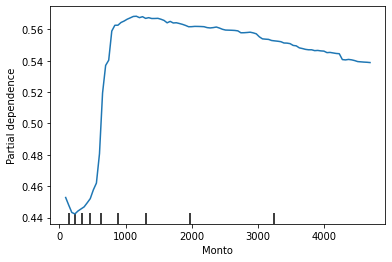

In [75]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    model,
    X,
    features=['Monto']
)

En este caso revela un comportamiento no lineal (forma de "U" asimétrica). 
Punto inicial en $100, la probabilidad empieza relativamente alta (cercana a 0.46).

El mínimo (para un X=200, Y=0.445), aquí sucede algo clave ya que el modelo identifica que las transacciones o montos cercanos a $200 son los de "menor riesgo" o menor probabilidad de la clase objetivo.

Interpretación: Es posible que este sea el rango de transacciones "normales" o legítimas más comunes, donde el modelo se siente seguro de que no hay anomalías. A partir de los X=200, la curva sube casi verticalmente hasta los X=500. (Cada dólar o unidad adicional que se suma al monto entre 200 y 500 dispara la preocupación del modelo). Superar los $1,000 ya coloca al registro en la categoría de mayor probabilidad de impacto (y la caida posterior suele ser ruido estadistico).

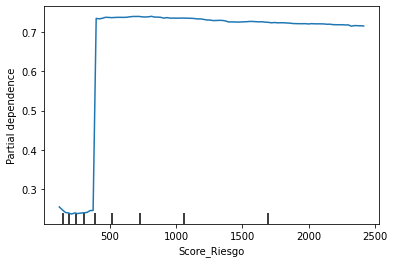

In [76]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    model,
    X,
    features=['Score_Riesgo']
)

Se ve un gran salto en el valor cercano a X=500 del score, significa que el modelo ha identificado que cruzar ese número cambia drásticamente el perfil del cliente y una vez alcanzado cierto nivel de riesgo el impacto ya es máximo. Osea que el modelo luego ya no distingue entre un "riesgo alto" y un "riesgo extremo", luego de ese valor todos tienen la misma probabilidad de pertenecer a la clase positiva (Fraude).
El hecho de que en X=400 el gráfico pegue un salto indica que ese es el punto de quiebre para el Random Forest.

Interpretación: Para el modelo un cliente con un score de 390 es drásticamente diferente a uno con 410. Es posible que a partir de 400 el riesgo se dispare o se entre en una categoría de "alta probabilidad" de la clase objetivo.

Este valor (400) debería ser la referencia para políticas de protección o un umbral a evitar. Cualquier registro que cruce este umbral cambia el veredicto del modelo de forma significativa. 

Una vez que el cliente pasa de 400, el modelo ya lo marcó como "riesgoso". Que luego suba a 1000, 1500 o 2500 no aporta información adicional relevante. El impacto en la predicción ya es máximo (o cercano al máximo) y se estabiliza.

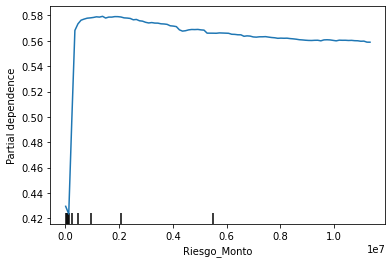

In [77]:
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    model,
    X,
    features=['Riesgo_Monto']
)


Con la tercera variable se ve que el modelo es extremadamente sensible al crecimiento conjunto del riesgo y el monto en sus valores iniciales.

Interpretación: Pequeños incrementos en el producto "Riesgo x Monto" disparan la probabilidad de la clase objetivo (se pasa de un impacto de 0.42 a 0.56). También hay un efecto de saturación una vez que el producto Riesgo_Monto llega a su valor mas alto, se procede a una caída leve (0.56 a 0.54) que aunque parece una contradicción (que a más riesgo-monto baje un poco la probabilidad) en modelos de Random Forest esto suele ser ruido estadístico.